## Example to use the different algorithms

In [47]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import logging
from copy import deepcopy
import numpy as np
import random

from spacebench import SpaceEnv
from spacebench.algorithms import OLS, SpatialPlus

# configure logging to print time
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

np.random.seed(0)
random.seed(0)

In [48]:
env_name = "healthd_pollutn_mortality_cont"
env = SpaceEnv(env_name, dir="downloads")

# randomly mask a covariate group to induce spatial confounding
dataset = env.make(missing_group="cs_population_density")
dataset_full = dataset.unmask()

# mask even further for visualization/demo purposes
dataset.covariates = dataset.covariates[:, :8]

logging.info(f"Masked model covariates shape: {dataset.covariates.shape}")
logging.info(f"Full model covariates shape: {dataset_full.covariates.shape}")

# print confounding score
logging.info(f"Confounding score: {dataset.confounding_score}")

21:36:00 DEBUG Missing covariate group: cs_population_density
21:36:00 INFO Masked model covariates shape: (3109, 16)
21:36:00 INFO Full model covariates shape: (3109, 33)
21:36:00 INFO Confounding score: {'erf': 0.023488299921154976, 'ate': nan, 'ite': 0.24424737691879272, 'importance': 0.019940831067926826}


In [49]:
# init models
models = {
    "OLS": OLS(),
    "SpatialPlus": SpatialPlus(k=100, max_iter=1000),
}

# make to store the solutions without missing confounders
models_full = deepcopy(models)

# fit all models
for name, model in models.items():
    logging.info(f"Fitting {name}...")
    model.fit(dataset)

# fit all models on the full dataset
for name, model in models_full.items():
    logging.info(f"Fitting {name} on full dataset...")
    model.fit(dataset_full)   

21:36:00 INFO Fitting OLS...
21:36:00 INFO Fitting SpatialPlus...
21:36:19 INFO Fitting OLS on full dataset...
21:36:19 INFO Fitting SpatialPlus on full dataset...


In [50]:
# estimate causal effects
preds = {}
preds_full = {}

for name, model in models.items():
    logging.info(f"Predicting {name}...")
    preds[name] = model.eval(dataset)

for name, model in models_full.items():
    logging.info(f"Predicting {name} on full dataset...")
    preds_full[name] = model.eval(dataset_full)

21:36:39 INFO Predicting OLS...
21:36:39 INFO Predicting SpatialPlus...
21:36:39 INFO Predicting OLS on full dataset...
21:36:39 INFO Predicting SpatialPlus on full dataset...


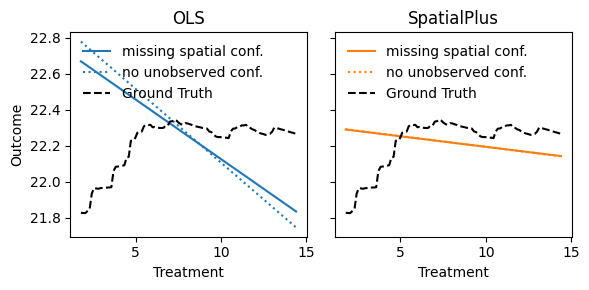

In [51]:
pal = plt.get_cmap("tab10")

treatment_values = dataset.treatment_values
ground_truth = dataset.counterfactuals.mean(0)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)
for i, (name, values) in enumerate(preds.items()):
    ax[i].plot(treatment_values, values["erf"], label="missing spatial conf.", c=pal(i))
    pass

for i, (name, values) in enumerate(preds_full.items()):
    ax[i].plot(treatment_values, values["erf"], label="no unobserved conf.", linestyle=":", c=pal(i))
    ax[i].plot(treatment_values, ground_truth, label="Ground Truth", linestyle="--", c="k")
    ax[i].legend(loc="upper left", frameon=False)
    ax[i].set_xlabel("Treatment")
    ax[i].set_title(name)
    if i == 0:
        ax[i].set_ylabel("Outcome")

# reduce space
plt.tight_layout()